# Задание 1: Оптимизация

In [1]:
import logging
from typing import List, Dict, Any

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig()
logger = logging.getLogger("lagrange")
logger.setLevel(logging.INFO)

In [2]:
import logging
from typing import List, Dict, Any

import numpy as np
import pandas as pd

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(f"Metric: {maximized_column}", extra={"value": optimal_statistics.get(maximized_column)})

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        log_dict = {
            "constraint value": round(constraint, 3),
            "optimal value": round(optimal_value, 3),
            "uplift (abs)": round(optimal_value - constraint, 3),
            "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
        }
        logger.info(f"Metric: {metric}")
        for key, value in log_dict.items():
            logger.info(f"{key}= {value}")


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df

In [3]:
# Функция для подсчета аплифта на предсказаниях
def calculate_uplifts(
    control_metrics: Dict[str, float],
    optimal_df: pd.DataFrame,
) -> None:
    for metric, control_value in control_metrics.items():
        test_value = optimal_df[metric].sum()
        uplift = round(test_value * 100 / control_value - 100)
        
        print(f"Control {metric}: {round(control_value)} руб.")
        print(f"Test margin: {round(test_value)} руб.")
        print(f"Uplift: {uplift} %")

In [4]:
# Функция для построения графика распределения скидок
def plot_distribution(df: pd.DataFrame) -> None:
    plt.hist(df["discount"], bins=10, color="blue", edgecolor="black")
    plt.title('Распределение скидок')
    plt.xlabel('Размер скидки')
    plt.ylabel('Количество товаров')
    plt.show()

# Подсчет метрик

In [5]:
df = pd.read_csv("../hm_solution_4_1/data/homework_3_2_solution.csv")
commission_df = pd.read_csv("../commission.csv")
df = df.merge(commission_df, on=["sku_id"], how="left")
df["revenue"] = df["orders_num"] * 1500
df["margin"] = df["revenue"] * df["commission"] + df["revenue"] * df["discount"]
df.head()

,sku_id,discount,orders_num,ds,commission,revenue,margin
0,2,-0.05,178.737688,20240101,0.5,268106.532678,120647.939705
1,2,-0.04,178.737688,20240101,0.5,268106.532678,123329.005032
2,2,-0.03,178.737688,20240101,0.5,268106.532678,126010.070359
3,2,-0.02,178.737688,20240101,0.5,268106.532678,128691.135686
4,2,-0.01,178.737688,20240101,0.5,268106.532678,131372.201012


# Подсчет контрольных метрик

In [6]:
control_df = df.copy(deep=True)
control_df = control_df[control_df["discount"] == 0.0]
control_df = control_df[["margin", "orders_num", "revenue"]].sum()
control_metrics = control_df.to_dict()
print(control_metrics)

{'margin': 527663534.1683493, 'orders_num': 1175435.3901393935, 'revenue': 1763153085.2090905}


# Оптимизация

In [7]:
optimal_df = optimize(
    df=df,
    # перебираем разные lambda для маржи
    lambda_config={
        "margin": np.arange(0.0, 0.001, 0.0001).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="orders_num",
    # указываем ограничения
    constraints={
        # умножаем на 1.01, так как нам нужно вырастить маржу не менее, чем на 1%
        "margin": control_metrics["margin"] * 1.01,
    },
    levels=["sku_id", "ds"],
    price_column="discount",
)

INFO:__main__:Start choosing optimal prices
INFO:__main__:Start calculating lagrangians, 10 lambda combinations
INFO:__main__:Ended calculating lagrangians
INFO:__main__:
              lambda_combination    orders_num        margin
0                     margin=0.0  1.176268e+06  4.670557e+08
1                  margin=0.0001  1.176103e+06  5.384509e+08
2                  margin=0.0002  1.175735e+06  5.409375e+08
3  margin=0.00030000000000000003  1.175100e+06  5.435062e+08
4                  margin=0.0004  1.174452e+06  5.453650e+08
INFO:__main__:
              lambda_combination    orders_num        margin
1                  margin=0.0001  1.176103e+06  5.384509e+08
2                  margin=0.0002  1.175735e+06  5.409375e+08
3  margin=0.00030000000000000003  1.175100e+06  5.435062e+08
4                  margin=0.0004  1.174452e+06  5.453650e+08
5                  margin=0.0005  1.173293e+06  5.479442e+08
INFO:__main__:Metric: orders_num
INFO:__main__:Metric: margin
INFO:__main__:constr

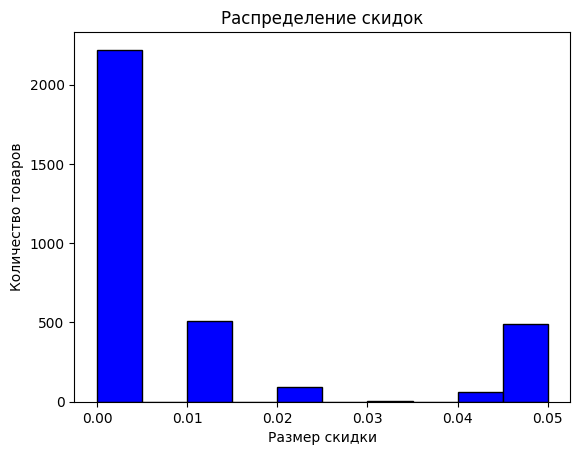

In [8]:
plot_distribution(df=optimal_df)

In [9]:
# Подсчитываем аплифты при выбранных скидках
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
)

Control margin: 527663534 руб.
Test margin: 538450928 руб.
Uplift: 2 %
Control orders_num: 1175435 руб.
Test margin: 1176103 руб.
Uplift: 0 %
Control revenue: 1763153085 руб.
Test margin: 1764153783 руб.
Uplift: 0 %


<font color="red">Мы не смогли вырастить заказы, но мы вырастили маржу на 2%, что тоже является успехом.</font>

In [10]:
optimal_df[["sku_id", "ds", "discount"]].to_csv("../hm_solution_4_1/data/homework_4_1_solution.csv", index=False)